## Using Ensemble Methods to Improve Toxic Comment Classification


### Category analysis

In [6]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yashwanthhirehalliswamy/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [7]:
import numpy as np
import pandas as pd

%matplotlib inline

# Visualization
import seaborn as sns
from matplotlib import pyplot as plt

import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from matplotlib_venn import venn3

from wordcloud import WordCloud

from collections import Counter
import re
import string
from nltk.corpus import stopwords
stop = stopwords.words('english')


sns.set(style="white", context="talk")


In [13]:
df_train = pd.read_csv('data/train.csv')
df_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


### Data Info

In [17]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
 8   none           159571 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 11.0+ MB


### Statistical summary of the dataset

In [18]:
df_train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,none
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805,0.898321
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420,0.302226
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Check for Null Values

In [19]:
df_train.isnull().values.any()

False

### Columns

In [14]:
COLUMNS = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

df_train['none'] = (df_train[COLUMNS].max(axis=1) == 0).astype(int)
COLUMNS.append('none')
CATEGORIES = COLUMNS.copy()

print(df_train.shape)
print(df_train.columns.values)

(159571, 9)
['id' 'comment_text' 'toxic' 'severe_toxic' 'obscene' 'threat' 'insult'
 'identity_hate' 'none']


### Distribution

#### Labels

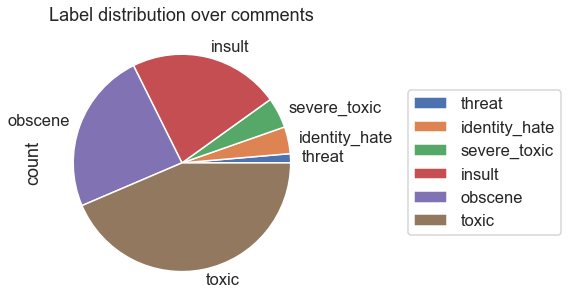

In [20]:
df_distribution = df_train[COLUMNS].sum().to_frame().rename(columns={0: 'count'}).sort_values('count')

df_distribution.drop('none').plot.pie(y='count',title='Label distribution over comments',
                                      figsize=(5, 5)).legend(loc='center left', bbox_to_anchor=(1.3, 0.5))

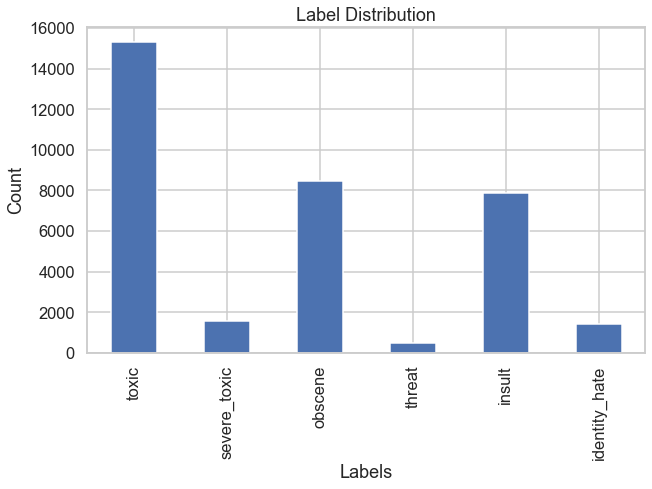

In [28]:
label_counts = df_train[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum()
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar')
plt.title('Label Distribution')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()

#### Number of comment for each label

In [29]:
df_comb = df_train.groupby(COLUMNS)\
                    .size()\
                    .sort_values(ascending=False)\
                    .reset_index()\
                    .rename(columns={0: 'count'})
df_comb.head(n=10)

,toxic,severe_toxic,obscene,threat,insult,identity_hate,none,count
0,0,0,0,0,0,0,1,143346
1,1,0,0,0,0,0,0,5666
2,1,0,1,0,1,0,0,3800
3,1,0,1,0,0,0,0,1758
4,1,0,0,0,1,0,0,1215
5,1,1,1,0,1,0,0,989
6,1,0,1,0,1,1,0,618
7,0,0,1,0,0,0,0,317
8,0,0,0,0,1,0,0,301
9,1,1,1,0,1,1,0,265


#### Outcomes:

1. As anticipated, the 'none' label dominates with a total of 86,061 comments.
2. The 'toxic' label, as the primary category, occupies all positions from rank 1 to 6 in the combinations.
3. Among these six ranks, 'obscene' appears in four instances.
4. Notably, the count of comments for each combination exhibits an exponential decline.

The three major labels are :

1. toxic
2. obscene
3. insult

#### Correlation matrix

<AxesSubplot:>

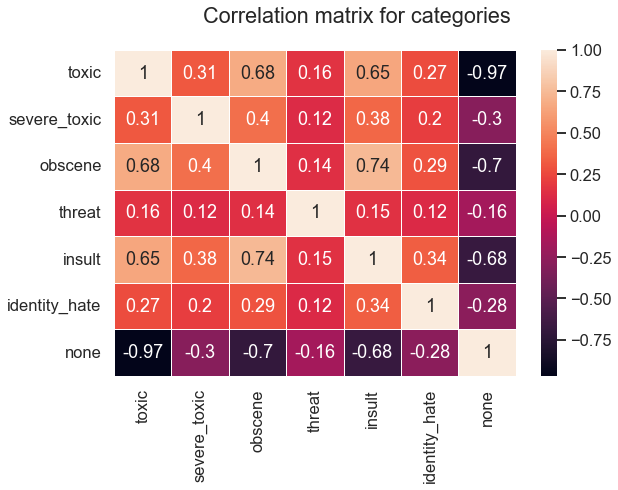

In [30]:
f, ax = plt.subplots(figsize=(9, 6))
f.suptitle('Correlation matrix for categories')
sns.heatmap(df_train[COLUMNS].corr(), annot=True, linewidths=.5, ax=ax)

The correlation matrix unveils intriguing patterns:

1. 'Toxic' exhibits strong correlations with 'obscene' and 'insult' at coefficients of 0.68 and 0.65, respectively.
2. The correlation between 'toxic' and 'severe_toxic' is notably lower at 0.31.
3. 'Insult' and 'obscene' display a substantial correlation factor of 0.74.
4. 'toxic' <-> 'severe_toxic'. The semantic of these two categories seems to show some kind of graduation between them
5. 'toxic' <-> 'insult' and 'toxic' <-> 'obscene'
6. 'insult' <-> 'obscene'


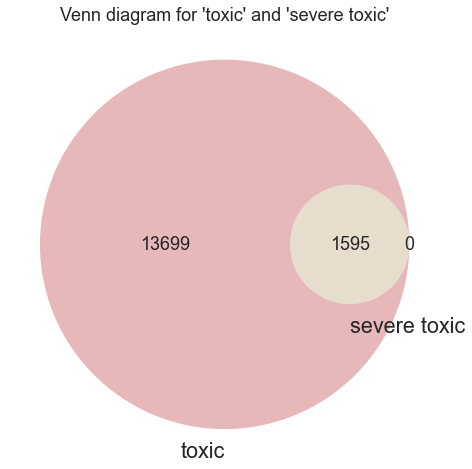

In [45]:
t = df_train[(df_train['toxic'] == 1) & (df_train['severe_toxic'] == 0)].shape[0]
s = df_train[(df_train['toxic'] == 0) & (df_train['severe_toxic'] == 1)].shape[0]

t_s = df_train[(df_train['toxic'] == 1) & (df_train['severe_toxic'] == 1)].shape[0]

plt.figure(figsize=(8, 8))
plt.title("Venn diagram for 'toxic' and 'severe toxic'")
venn2(subsets = (t, s, t_s), 
      set_labels=('toxic', 'severe toxic'))
plt.show()

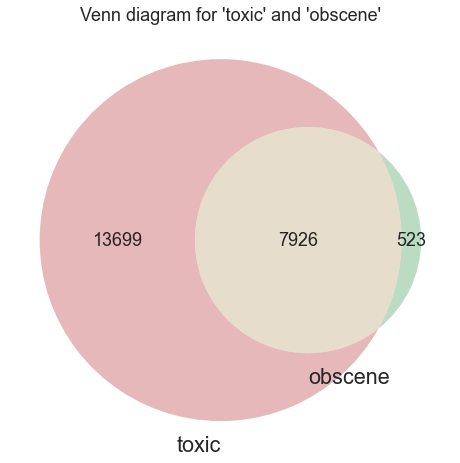

In [38]:
o = df_train[(df_train['toxic'] == 0) & (df_train['obscene'] == 1)].shape[0]

t_o = df_train[(df_train['toxic'] == 1) & (df_train['obscene'] == 1)].shape[0]

plt.figure(figsize=(8, 8))
plt.title("Venn diagram for 'toxic' and 'obscene'")
venn2(subsets = (t, o, t_o), 
      set_labels=('toxic', 'obscene'))
plt.show()


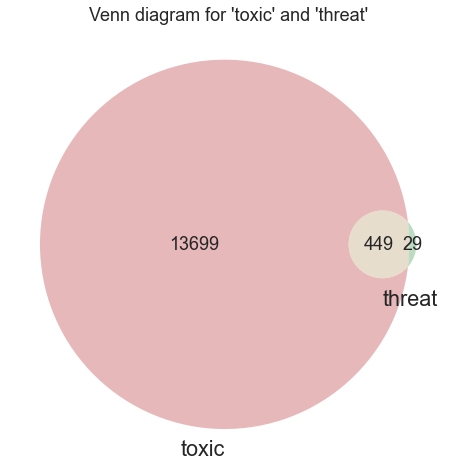

In [39]:
th = df_train[(df_train['toxic'] == 0) & (df_train['threat'] == 1)].shape[0]

t_th = df_train[(df_train['toxic'] == 1) & (df_train['threat'] == 1)].shape[0]

plt.figure(figsize=(8, 8))
plt.title("Venn diagram for 'toxic' and 'threat'")
venn2(subsets = (t, th, t_th), 
      set_labels=('toxic', 'threat'))
plt.show()

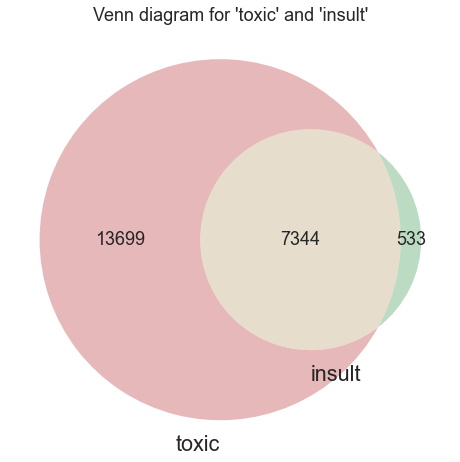

In [40]:
i = df_train[(df_train['toxic'] == 0) & (df_train['insult'] == 1)].shape[0]

t_i = df_train[(df_train['toxic'] == 1) & (df_train['insult'] == 1)].shape[0]

plt.figure(figsize=(8, 8))
plt.title("Venn diagram for 'toxic' and 'insult'")
venn2(subsets = (t, i, t_i), 
      set_labels=('toxic', 'insult'))
plt.show()

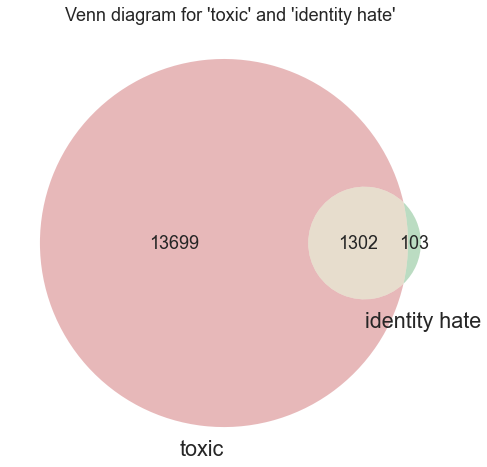

In [46]:
ih = df_train[(df_train['toxic'] == 0) & (df_train['identity_hate'] == 1)].shape[0]

t_ih = df_train[(df_train['toxic'] == 1) & (df_train['identity_hate'] == 1)].shape[0]

plt.figure(figsize=(8, 8))
plt.title("Venn diagram for 'toxic' and 'identity hate'")
venn2(subsets = (t, ih, t_ih), 
      set_labels=('toxic', 'identity hate'))
plt.show()

    The 'severe_toxic' category is entirely subsumed within the 'toxic' category, which supports the semantic connection between the two category names. The relatively modest 0.31 correlation factor can be attributed to the fact that 'severe_toxic' represents a relatively small proportion (11.67%) of the 'toxic' category.

Before delving into the word-level analysis, it's essential to examine the structural aspects of the comments:

1. Total Length: This metric could potentially indicate the level of the writer's involvement, whether it's positive or 'negative.'

2. Total Number of Carriage Returns: The presence of carriage returns may suggest a specific structural or formatting pattern within the comment text.

In [47]:
df_train['total_length'] = df_train['comment_text'].str.len()
df_train['new_line'] = df_train['comment_text'].str.count('\n'* 1)
df_train['new_small_space'] = df_train['comment_text'].str.count('\n'* 2)
df_train['new_medium_space'] = df_train['comment_text'].str.count('\n'* 3)
df_train['new_big_space'] = df_train['comment_text'].str.count('\n'* 4)

df_train['new_big_space'] = df_train['comment_text'].str.count('\n'* 4)
df_train['uppercase_words'] = df_train['comment_text'].apply(lambda l: sum(map(str.isupper, list(l))))
df_train['question_mark'] = df_train['comment_text'].str.count('\?')
df_train['exclamation_mark'] = df_train['comment_text'].str.count('!')

FEATURES = ['total_length', 
            'new_line', 
            'new_small_space', 
            'new_medium_space', 
            'new_big_space', 
            'uppercase_words',
            'question_mark',
            'exclamation_mark']
COLUMNS += FEATURES

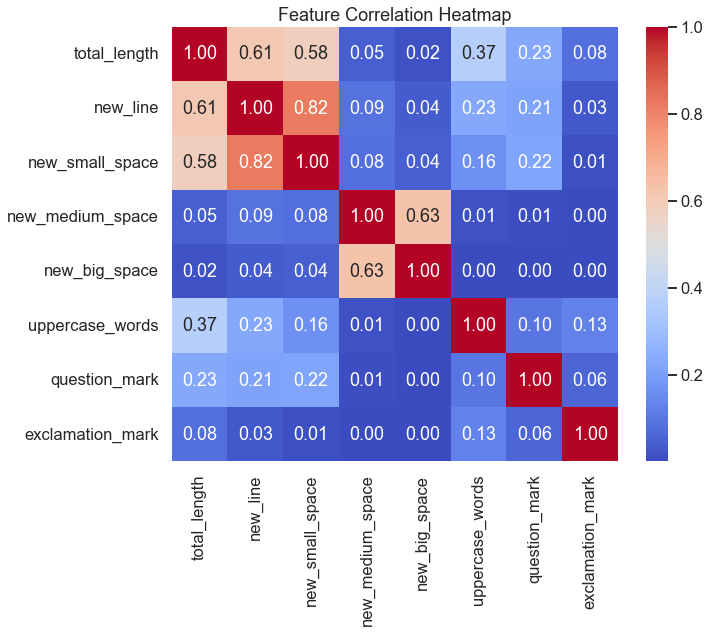

In [50]:
feature_correlations = df_train[FEATURES].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(feature_correlations, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

1. The new correlation matrix with the added features does not show any strong correlations.
2. One thing worth noting is that 'uppercase_words' (which could be assimilated to 'yelling') is slightly more correlated.
3. 'uppercase_words' are correlated with 'exclamation_mark' up to 0.13 which could mean that people express the urge to add as many '!' as possible when they are 'yelling' ;)

### Word analysis

In [57]:
word_counter = {}


def clean_text(text):
    text = re.sub('[{}]'.format(string.punctuation), ' ', text.lower())
    return ' '.join([word for word in text.split() if word not in (stop)])

for categ in CATEGORIES:
    d = Counter()
    df_train[df_train[categ] == 1]['comment_text'].apply(lambda t: d.update(clean_text(t).split()))
    word_counter[categ] = pd.DataFrame.from_dict(d, orient='index')\
                                        .rename(columns={0: 'count'})\
                                        .sort_values('count', ascending=False)

In [58]:
for w in word_counter:
    wc = word_counter[w]

    wordcloud = WordCloud(
          background_color='black',
          max_words=200,
          max_font_size=100, 
          random_state=4561
         ).generate_from_frequencies(wc.to_dict()['count'])

    fig = plt.figure(figsize=(12, 8))
    plt.title(w)
    plt.imshow(wordcloud)
    plt.axis('off')

    plt.show()

ValueError: Only supported for TrueType fonts